In [1]:
from sklearn.preprocessing import StandardScaler
import joblib
import torch
import torch.nn as nn

import pandas as pd
import numpy as np

In [2]:
class ANN(nn.Module, ):
    def __init__(self,input_size, hidden):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden, 1)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        # x = self.relu(x)
        return x

In [3]:
def get_model(input_size, hidden, model_path):
    model = ANN(input_size, hidden)
    model.load_state_dict(torch.load(model_path))
    model.fc2 = nn.Identity()
    model.eval()
    return model

In [4]:
# model = get_model(len(feature_order), 'models/book_rating_model.pth')

In [5]:
def get_embedding(mtrx, model):
    X = scaler.transform(mtrx)
    inp = torch.Tensor(X)
    
    emb = model(inp)
    # print(emb)
    return emb.detach().numpy()

In [6]:
def extract_row_and_remainder(array, index):
    
    # Trích xuất vector tại dòng index
    row_vector = array[index, :]
    
    # Tạo ma trận mới bằng cách xóa dòng tại index
    new_matrix = np.delete(array, index, axis=0)
    
    return row_vector, new_matrix

In [7]:
def cosine_similarity(x, y):
    norm_x = np.linalg.norm(x)
    norm_y = np.linalg.norm(y,axis=1)
    
    cosim = x@y.T/(norm_x*norm_y)
    return cosim

In [8]:
def dcg(relevance_scores, k=None):
    """
    Compute the Discounted Cumulative Gain (DCG) for a list of relevance scores.
    
    Parameters:
    relevance_scores (array-like): Relevance scores in the order of results.
    k (int): Rank position up to which DCG is to be calculated (optional).

    Returns:
    float: DCG value.
    """
    # dcg = sum[cosine similarity/log2(idx+2)] 
    if k is None:
        k = len(relevance_scores)
    relevance_scores = np.asfarray(relevance_scores)[:k]
    if relevance_scores.size:
        return np.sum(relevance_scores / np.log2(np.arange(2, relevance_scores.size + 2)))
    return 0.0

In [9]:
genres_data = pd.read_csv('fin_genres.csv')

In [10]:
genres_data.loc[genres_data['Genre'] == 'other', 'NumberOfPeople'] += 1

In [11]:
genre_mat = genres_data.pivot(index='bookId', columns='Genre', values='NumberOfPeople').fillna(0)

In [12]:
genre_mat = genre_mat.applymap(lambda x: 1 if x > 0 else 0)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_22132\2312863438.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  genre_mat = genre_mat.applymap(lambda x: 1 if x > 0 else 0)


In [13]:
genre_mat['bookId'] = genre_mat.index

In [14]:
genre_mat['index'] = range(0, len(genre_mat))

In [15]:
genre_mat.set_index("index", inplace = True)

In [16]:
book_data = pd.read_csv('book_data.csv')

In [17]:
book_data['Series'] = book_data['Series'].fillna(0)

# Convert all non-zero values to 1
book_data['Series'] = np.where(book_data['Series'] == 0, 0, 1)

In [18]:
book_data['num_years'] = 2024-book_data['PublishYear']

In [19]:
book_data_reduced = book_data[['BookID', 'Pages', 'Book format', 'Series', 'num_years']]

In [20]:
merged_data = pd.merge(genre_mat, book_data_reduced, left_on='bookId', right_on='BookID')

In [21]:
merged_data = pd.get_dummies(merged_data, columns=['Book format'])

In [22]:
X = merged_data.drop(columns=['bookId', 'BookID'])

In [23]:
X.shape

(3420, 59)

In [24]:
scaler = joblib.load('models/scaler.save')

d:\application and set up\anaconda\Lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.24.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [29]:
model = get_model(X.shape[1],'models/book_rating_model.pth')

TypeError: get_model() missing 1 required positional argument: 'model_path'

In [26]:
embeddings = get_embedding(X)
embeddings.shape

TypeError: get_embedding() missing 1 required positional argument: 'model'

In [27]:
num_features = [8,10,16,20,30,32,40,50]

In [32]:
dcgs = []
for i in num_features:
    dcg_list = []
    model = get_model(X.shape[1], i, f'models/book_rating_model_{i}.pth')
    embeddings = get_embedding(X, model)
    for j in range(X.shape[0]):
        row_vector, new_matrix = extract_row_and_remainder(embeddings, j)
        cos_sim = cosine_similarity(row_vector, new_matrix)
        sort_sim = np.sort(cos_sim)[::-1]
        metric = dcg(sort_sim, k=None)
        dcg_list.append(metric)
    dcgs.append(sum(dcg_list)/X.shape[0])
    print(f'Model {i} has metric {sum(dcg_list)/X.shape[0]}')
    

FileNotFoundError: [Errno 2] No such file or directory: 'models/book_rating_model_8.pth'

In [ ]:
dcgs

[213.74610948866064,
 200.09521316879497,
 190.82084988784433,
 175.15676533455874,
 167.45206332097155,
 168.37552192852328,
 164.6921721893491,
 150.81484831477894]

ValueError: x and y must have same first dimension, but have shapes (8,) and (0,)

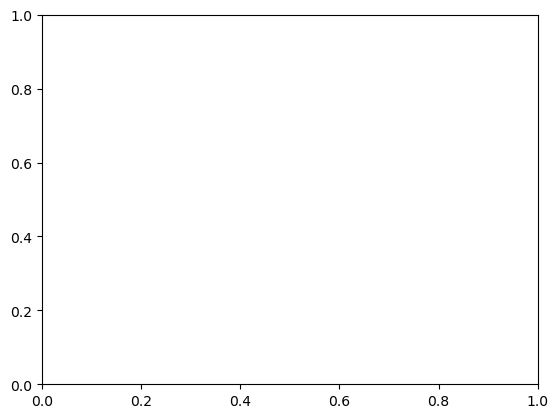

In [31]:
import matplotlib.pyplot as plt

plt.plot(num_features, dcgs)
plt.xlabel('number of features')
plt.ylabel('DCG')
plt.title('Discounted Cumulative Gain for each number of features')
plt.show()